In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

* Feature Information 

 - 0 : label 해당 유저가 목록에 진입하고 1시간 이내에 구매했는지 여부
 - 1 : 사용 플랫폼 A
 - 2 : 사용 플랫폼 B
 - 3 : 사용 플랫폼 C
 - 4 : 사용 플랫폼 D
 - 5 : 목록 진입시점 방문 총 세션 수 (범위별로 부여된 순차 ID)
 - 6 : 작품을 나타내는 해쉬
 - 7-9 : 개인정보
 - 10-109 : 주요 작품 구매 여부
 - 110 : 작품 태그 정보
 - 111 : 구매할 때 필요한 코인
 - 112 : 완결 여부
 - 113-122 : 스케쥴 정보
 - 123-140 : 장르 정보
 - 141 : 해당 작품의 마지막 에피소드 발행 시점 (범위별로 부여된 순차 ID)
 - 142 : 단행본 여부
 - 143 : 작품 발행 시점 (범위별로 부여된 순차 ID)
 - 144 : 총 발행 에피소드 수 (범위별로 부여된 순차 ID)
 - 145-150 : 작품 태그 정보
 - 151-166 : 유저의 성향 정보 (과거에 구매를 했을 때만 기록)

In [2]:
# 데이터 불러오기

data = pd.read_csv("lezhin_dataset_v2_training.tsv.gz", sep="\t", header=None)

In [3]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650965 entries, 0 to 650964
Columns: 167 entries, 0 to 166
dtypes: float64(16), int64(148), object(3)
memory usage: 919.7 MB


In [4]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,0,0,0,0,1,1,001C9D9B,8337B6FB,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.2580,0.0030,NaN,NaN
1,0,0,0,0,1,1,001C9D9B,90D8AB70,1,NaN,...,NaN,0.5000,NaN,NaN,NaN,NaN,0.5000,NaN,NaN,NaN
2,0,0,0,0,1,1,001C9D9B,ABC21E80,1,NaN,...,NaN,0.0187,0.0047,NaN,NaN,NaN,0.0287,0.0055,NaN,NaN
3,0,0,0,0,1,1,001C9D9B,C17967D1,0,69EF2C8F,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0186,NaN,NaN,NaN
4,0,0,0,0,1,1,002B4BDE,AF145784,0,NaN,...,NaN,0.0207,NaN,NaN,NaN,NaN,0.2805,0.0692,NaN,NaN


* 주로 유저의 성향 정보 feature들에서 null 값들이 많다.
    * 과거에 구매를 했을 때만 기록했기 때문에 null 값들이 많다.

In [5]:
data.isnull().sum()

0           0
1           0
2           0
3           0
4           0
5           0
6           0
7           0
8           0
9      505082
10          0
11          0
12          0
13          0
14          0
15          0
16          0
17          0
18          0
19          0
20          0
21          0
22          0
23          0
24          0
25          0
26          0
27          0
28          0
29          0
        ...  
137         0
138         0
139         0
140         0
141         0
142         0
143         0
144         0
145         0
146         0
147         0
148         0
149         0
150         0
151    548936
152    187889
153    273017
154    566513
155    231231
156    445505
157    650343
158    306819
159    542704
160    650672
161    649979
162    642925
163     91054
164    276227
165    650889
166    650903
Length: 167, dtype: int64

In [6]:
# null_data만 따로 추출
null_feature = np.where(data.isnull().sum() != 0)
null_data = data.iloc[:, null_feature[0]]
#null_data.to_csv('null_data.csv')

In [7]:
# 구매 X : 429172, 구매 O : 221792 약 2배정도 Label 비율 차이 있음. 
# undersampling, or oversampling 고려
data[0].value_counts()

0    429172
1    221793
Name: 0, dtype: int64

* 각 feature들과 target사이의 상관관계 파악
    * feature들 간 correlation, 그리고 feature와 correlation 값을 기반으로 된 heatmap 

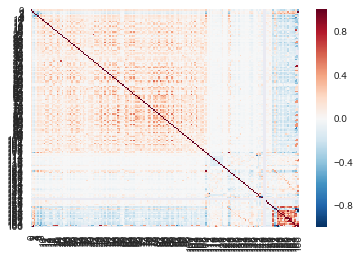

In [8]:
sns.heatmap(data.corr())
plt.show()

In [9]:
# target과 관련성이 높은 feature 상위 50개 
corrmat = data.corr()
cols = corrmat.nlargest(50, data[0])[0].index
cols

Int64Index([  0, 110, 124,  27,   4,  61, 165,  11,  46,  50,  51,  48,  19,
             56,  66,  14,  53,  75,  93,  22,   8,  89,  90,  20,  84, 101,
             87,  78,  82,  62,  15,  57,  80,  21,  86, 120,  97, 104,  81,
             68,  45,  28,  12,  25,  10,  64,  41,  54,  44,  29],
           dtype='int64')

In [10]:
# object type data 찾기
object_type_data = data.select_dtypes(include=['object']).columns.values
object_type_data

array([6, 7, 9], dtype=int64)

# EDA Process
1. 사용 플랫폼별 1시간 이내 구매 여부 관계
2. 목록 진입시점 방문 총 세션 수와 1시간 이내 구매 여부 관계
3. 작품과 1시간 이내 구매 여부 관계
4. 주요 작품 구매 여부와 1시간 이내 구매 여부 관계
5. 작품 태그 정보와 1시간 이내 구매 여부 관계
6. 완결여부와 1시간 이내 구매 여부 관계
7. 스케쥴 정보와 1시간 이내 구매 여부 관계
8. 장르 정보와 1시간 이내 구매 여부 관계
9. 마지막 에피소드 발행 시점과 1시간 이내 구매 여부 관계
10. 단행본 여부와 1시간 이내 구매 여부 관계
11. 작품 발행 시점과 1시간 이내 구매 여부 관계
12. 총 발행 에피소드 수와 1시간 이내 구매 여부 관계
13. 유저 성향 정보와 1시간 이내 구매 여부 관계

### 사용 플랫폼별 1시간 이내 구매 여부 관계

* 사용 플랫폼별 그래프 살펴보기
    * 먼저 그래프를 보면 플랫폼 A와 플랫폼 B를 사용 했을 때는 구매율이 떨어짐
    * 그리고 플랫폼 C를 사용했을 때는 구매율이 약간 올라가고 플랫폼 D를 사용했을 때 구매율이 많이 올라간 것을 확인할 수 있음.

In [11]:
mpl.rc('font', family='nanumgothic')
mpl.rc('axes', unicode_minus=False)

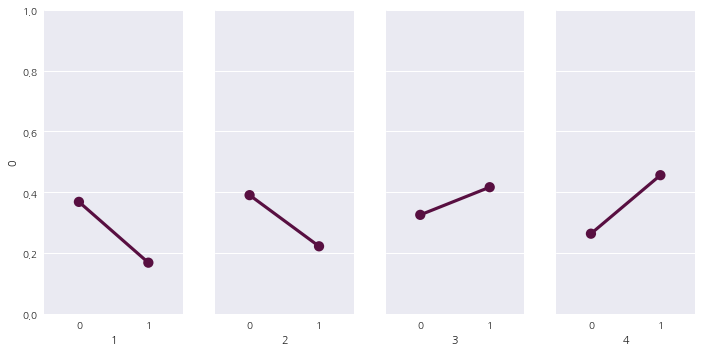

In [12]:
graph1 = sns.PairGrid(data, y_vars=0,
                 x_vars=[1,2,3,4],
                 size=5, aspect=.5)
graph1.map(sns.pointplot, color=sns.xkcd_rgb["plum"])
graph1.set(ylim=(0, 1))
sns.despine(fig=graph1.fig, left=True)

### 목록 진입지점 방문 총 세션수와 1시간 이내 구매 여부 관계
* ID는 세션 수 범위별로 부여된 ID이다.
* ID별로 1번 ID에서 구매비율이 가장 높게 나온다.

In [13]:
eda_session = pd.DataFrame({"세션 수 범위별로 부여된 ID" : data[5],
                                    "구매여부" : data[0]})
eda_session.head()

,구매여부,세션 수 범위별로 부여된 ID
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [14]:
groupby_session = eda_session.groupby(['세션 수 범위별로 부여된 ID', "구매여부"]).size()
groupby_session_ratio = groupby_session \
/eda_session.groupby(["세션 수 범위별로 부여된 ID"]).size()
session_df = pd.DataFrame(groupby_session)
session_df.columns = ['비구매/구매 갯수']
session_df['비구매/구매 비율'] = groupby_session_ratio
session_df

비구매/구매 갯수  비구매/구매 비율
세션 수 범위별로 부여된 ID 구매여부                      
1                0         12927   0.535679
                 1         11205   0.464321
2                0          6114   0.590782
                 1          4235   0.409218
3                0          5242   0.617723
                 1          3244   0.382277
4                0          4720   0.630258
                 1          2769   0.369742
5                0          4690   0.648776
                 1          2539   0.351224
6                0          4514   0.659363
                 1          2332   0.340637
7                0          4330   0.652108
                 1          2310   0.347892
8                0          4266   0.642954
                 1          2369   0.357046
9                0          4333   0.665796
                 1          2175   0.334204
10               0          4192   0.680962
                 1          1964   0.319038
11               0          4259   0.679917
                 1          2005   0.320083
12               0          4003   0.693040
                 1          1773   0.306960
13               0          4306   0.678538
                 1          2040   0.321462
14               0          3847   0.688563
                 1          1740   0.311437
15               0          3835   0.684455
                 1          1768   0.315545
...                          ...        ...
2205             1             1   1.000000
2221             0             1   0.500000
                 1             1   0.500000
2236             1             1   1.000000
2240             1             1   1.000000
2247             0             1   1.000000
2251             0             1   1.000000
2305             0             1   0.500000
                 1             1   0.500000
2314             1             1   1.000000
2322             1             4   1.000000
2335             0             2   1.000000
2345             1             1   1.000000
2348             0             1   1.000000
2558             1             1   1.000000
2559             0             1   1.000000
3007             0             1   1.000000
3008             0             1   1.000000
3032             0             1   1.000000
3033             1             2   1.000000
3063             1             1   1.000000
3076             0             1   1.000000
3089             0             1   1.000000
3105             0             1   1.000000
3109             0             1   1.000000
3147             1             1   1.000000
3502             0             1   1.000000
3532             0             1   1.000000
4939             0             1   1.000000
6807             0             1   1.000000

[2677 rows x 2 columns]

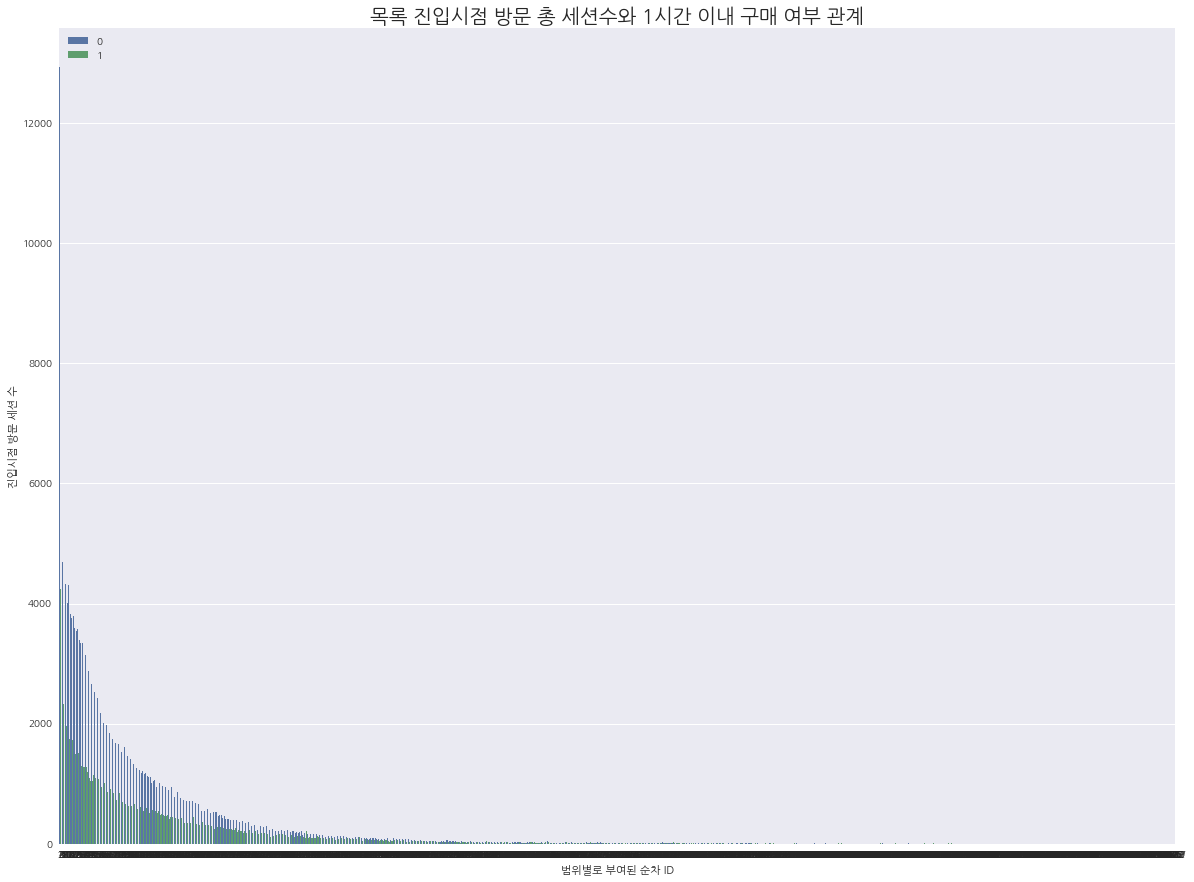

In [15]:
plt.figure(figsize=(20,15))
sns.countplot(x=5, hue=0, data=data)
plt.title(u'목록 진입시점 방문 총 세션수와 1시간 이내 구매 여부 관계', fontsize=20)
plt.xlabel(u'범위별로 부여된 순차 ID')
plt.ylabel(u'진입시점 방문 세션 수')
plt.show()

### 작품과 1시간 이내 구매 여부 관계

* 이 데이터에서 각 row는 유저마다 데이터이기 때문에 이렇게 해석해도 가능할 것 같다.
    * 인기가 많은 작품일수록 조회수가 많을 것이고, 인기가 많은 작품일 수록 유저가 1시간 이내에 구매할 확률이 높다.
    * 인기가 많지 않는 작품은 조회수가 적고, 조회수가 적은 작품은 구매할 확률이 높을 수도 있지만 통계적으로 유의미하지 않다.

In [16]:
print('작품수 :', len(data[6].unique()))
print('작품명 :', data[6].unique())

작품수 : 3559
작품명 : ['001C9D9B' '002B4BDE' '00A49090' ..., 'BEA5955B' 'C019555D' 'B23EDB7E']


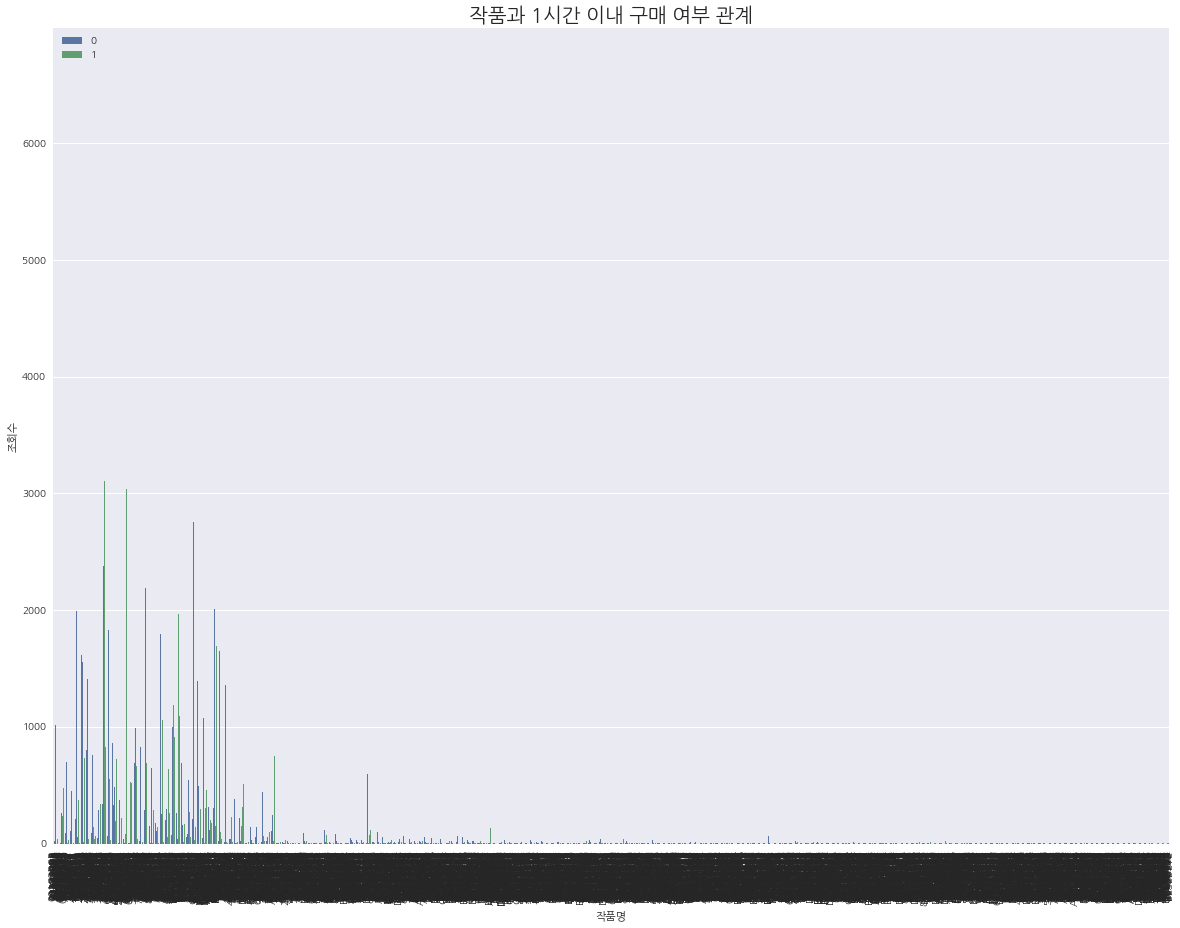

In [17]:
plt.figure(figsize=(20,15))
sns.countplot(x=6, hue=0, data=data)
plt.title(u'작품과 1시간 이내 구매 여부 관계', fontsize=20)
plt.xlabel(u'작품명')
plt.ylabel(u'조회수')
plt.xticks(rotation=90)
plt.show()

In [18]:
exploration = pd.DataFrame({'구매여부' : data[0], 
                            '작품' : data[6]})
exploration.head()

,구매여부,작품
0,0,001C9D9B
1,0,001C9D9B
2,0,001C9D9B
3,0,001C9D9B
4,0,002B4BDE


In [19]:
groupby_df = pd.DataFrame(exploration.groupby(['작품', '구매여부']).size())
groupby_df.columns = ['비구매/구매 갯수']
groupby_df['비구매/구매 비율'] = exploration.groupby(['작품', '구매여부']).size() \
/ exploration.groupby(['작품']).size()

In [20]:
groupby_df

비구매/구매 갯수  비구매/구매 비율
작품       구매여부                      
001C9D9B 0           183   0.672794
         1            89   0.327206
002B4BDE 0           358   0.617241
         1           222   0.382759
0030E221 0             2   0.400000
         1             3   0.600000
00343701 0             2   0.500000
         1             2   0.500000
003C31DA 0             3   1.000000
004259EF 0             1   1.000000
004D740D 0             1   1.000000
00545B4F 0            95   0.748031
         1            32   0.251969
00548AD2 0             2   1.000000
00563F3B 1             1   1.000000
0071D229 1             1   1.000000
0072CE25 0             2   1.000000
00A49090 0          3484   0.396721
         1          5298   0.603279
00A5099D 0            32   0.727273
         1            12   0.272727
00AC8ED3 0             1   1.000000
00E3ED9E 0             7   1.000000
00EC53C4 0            63   0.463235
         1            73   0.536765
01161AAA 0             1   1.000000
011A000A 0             6   0.600000
         1             4   0.400000
012831C2 0            35   0.729167
         1            13   0.270833
...                  ...        ...
FE9E25D2 0             5   1.000000
FE9FC289 0             2   1.000000
FEB2AD6A 0             4   1.000000
FED33392 0             1   1.000000
FEE17FB8 0             1   1.000000
FF1E4832 0             1   1.000000
FF31C718 0             5   0.416667
         1             7   0.583333
FF455F4A 0            27   0.870968
         1             4   0.129032
FF4D5FBB 0             1   1.000000
FF5DBAC3 1             1   1.000000
FF6C9FC2 0             5   1.000000
FF6D89C3 0             5   0.208333
         1            19   0.791667
FF7259D4 0             1   1.000000
FF77B8FC 0           505   0.656697
         1           264   0.343303
FFA39014 0           151   0.364734
         1           263   0.635266
FFB6A968 0             7   0.583333
         1             5   0.416667
FFB6E9B2 0             1   1.000000
FFC5BE2E 0             2   1.000000
FFD52F3C 0            27   0.586957
         1            19   0.413043
FFE303DC 1             1   1.000000
FFEABD22 0            23   0.793103
         1             6   0.206897
FFF1FD1F 0             1   1.000000

[5163 rows x 2 columns]

### 주요 작품 구매 여부와 1시간 이내 구매 여부와의 관계

* 데이터의 의미를 알아야 한다. 이 데이터가 의미하는 바는 무엇일까..?
    * 구매여부라면 구매했다, 구매 안했다 이런 식으로 이해해도 될까?
        * 구매 했다면 1, 구매하지 않았다면 0. 데이터 컬럼마다 주요 작품을 의미하겠지?

In [21]:
data.iloc[:, 10:110].head()

,10,11,12,13,14,15,16,17,18,19,...,100,101,102,103,104,105,106,107,108,109
0,0,11,0,0,1,12,0,0,0,5,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,25,6,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,34,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,6,0,0,0,0,0,...,0,0,0,0,0,6,0,0,0,0


In [47]:
data[10].unique()

array([ 0,  3,  5, 42, 37,  6, 44, 16, 11,  4, 20, 39,  8,  1, 45, 18, 15,
        2,  7, 43, 12, 19,  9, 26, 46, 14, 36, 32, 17, 29, 40, 41, 10, 31,
       27, 24, 21, 38, 34, 23, 28, 35, 25, 22, 13, 33, 30, 47], dtype=int64)

In [48]:
data[11].unique()

array([11,  0,  1, 34,  2,  5, 10, 13,  4,  6, 31, 12,  9,  7,  3,  8, 32,
       14, 24, 21, 33, 18, 37, 36, 19, 35, 15, 16, 17, 27, 28, 20, 23, 29,
       26, 30, 25, 22], dtype=int64)

### 작품 태그 정보와 1시간 이내 구매 여부와의 관계

* 0이면 태그정보가 없고 1이면 태그정보가 있다고 하면 태그 정보가 있을 때 구매비율이 더 높은 것을 알 수 있다.

In [22]:
data.loc[:, 110]

0         1
1         1
2         1
3         1
4         1
5         1
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        1
23        1
24        0
25        1
26        1
27        1
28        0
29        1
         ..
650935    0
650936    0
650937    0
650938    0
650939    0
650940    0
650941    0
650942    0
650943    0
650944    0
650945    0
650946    0
650947    0
650948    0
650949    0
650950    0
650951    0
650952    0
650953    0
650954    0
650955    0
650956    0
650957    0
650958    0
650959    0
650960    0
650961    0
650962    0
650963    0
650964    0
Name: 110, Length: 650965, dtype: int64

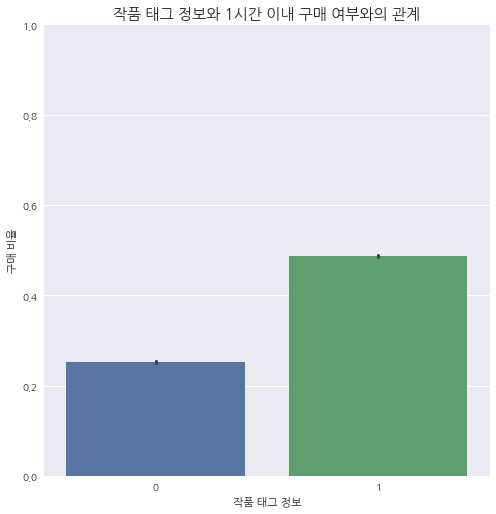

In [23]:
sns.factorplot(x=110, y=0, data=data, kind='bar', size=7)
plt.xlabel('작품 태그 정보')
plt.ylabel('구매 비율')
plt.title('작품 태그 정보와 1시간 이내 구매 여부와의 관계', fontsize=15)
plt.ylim(0, 1)
plt.show()

### 구매할 때 필요한 코인과 1시간 이내 구매 여부와의 관계
* 구매할 때 필요한 코인 갯수가 0개일 때 구매비율이 가장 높은 것을 알 수 있다.
* 코인 갯수가 5개가 필요한 작품의 구매비율도 그 다음으로 높게 나왔다.
* 코인 갯수가 50개 필요한 작품의 경우 구매비율이 많이 떨어지는 것을 알 수 있다.

In [24]:
data.loc[:, 111].value_counts()

3     445848
2     116680
0      60518
4      23421
1       2242
5       1180
50      1076
Name: 111, dtype: int64

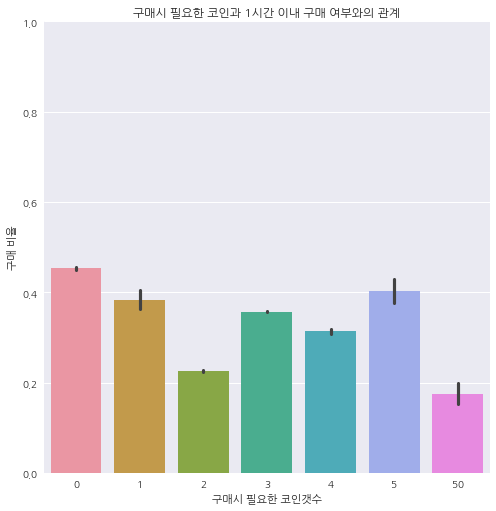

In [25]:
sns.factorplot(x=111, y=0, data=data, kind='bar', size=7)
plt.xlabel('구매시 필요한 코인갯수')
plt.ylabel('구매 비율')
plt.title('구매시 필요한 코인과 1시간 이내 구매 여부와의 관계')
plt.ylim(0, 1)
plt.show()

### 완결 여부와 1시간 이내 구매 여부와의 관계

* 완결 된 작품의 경우 1시간 이내에 구매 할 확률이 완결이 되지 않은 작품에 비해 약간 높은 것을 그래프로 알 수 있다.

In [26]:
data.loc[:, 112].value_counts()

0    518854
1    132111
Name: 112, dtype: int64

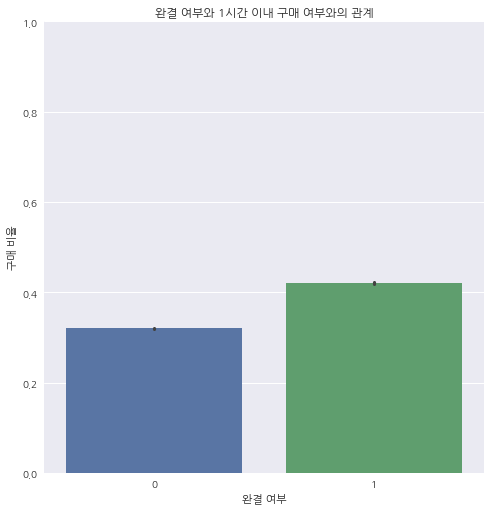

In [27]:
sns.factorplot(x=112, y=0, data=data, kind='bar', size=7)
plt.xlabel('완결 여부')
plt.ylabel('구매 비율')
plt.title('완결 여부와 1시간 이내 구매 여부와의 관계')
plt.ylim(0, 1)
plt.show()

### 스케쥴 정보와 1시간 이내 구매 여부와의 관계
* 120 feature의 경우 스케쥴정보가 있으면 구매 비율이 약 0.5로 다른 스케쥴 정보에 비해서 구매비율이 높은 것을 알 수 있다.
* 113, 114, 116, 118, 119, 121, 122 feature들의 경우 이 스케쥴 정보들을 보면 이 스케쥴 정보들이 있으면 오히려 구매비율이 낮아지는 것을 볼 수 있다.
    * 그 중에서도 **119**, **121** 스케쥴 feature들의 경우 구매비율이 낮은 것을 알 수 있다.

In [28]:
data.iloc[:, 113:123].head()

,113,114,115,116,117,118,119,120,121,122
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0


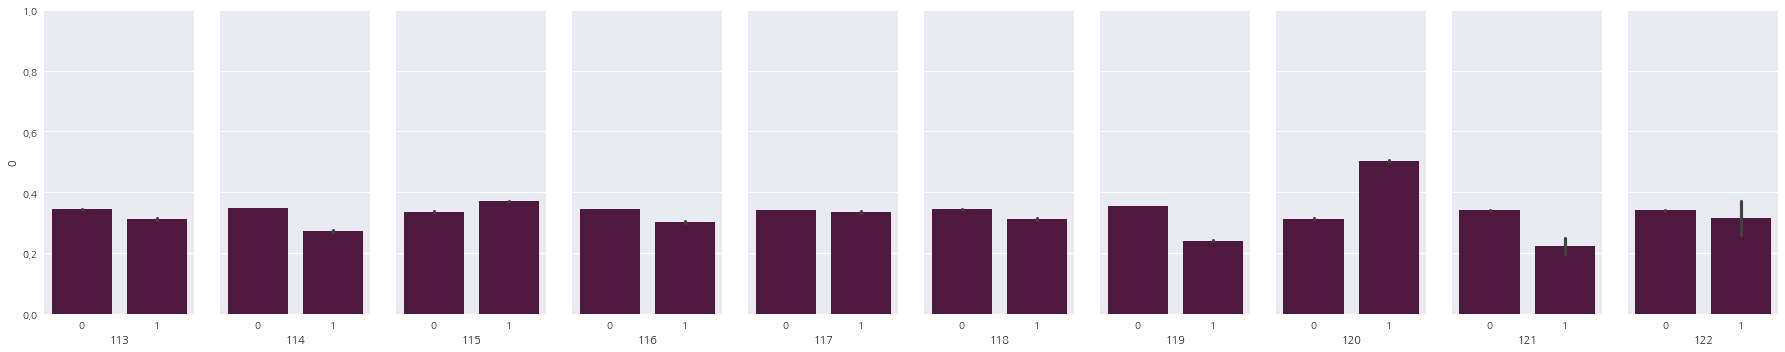

In [29]:
graph2 = sns.PairGrid(data, y_vars=0,
                 x_vars=[113,114,115,116,117,118,119,120,121,122],
                 size=5, aspect=.5)
graph2.map(sns.barplot, color=sns.xkcd_rgb["plum"])
graph2.set(ylim=(0, 1))
sns.despine(fig=graph2.fig, left=True)

### 장르 정보와 1시간 이내 구매 여부와의 관계
* 124, 125, 129, 134, 135장르일 경우 구매비율이 높다.
    * 그 중에 135 장르일 경우 구매비율이 가장 높다.

In [30]:
data.iloc[:, 123:141].head()

,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [31]:
data.iloc[:, 123:141].columns

Int64Index([123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
            136, 137, 138, 139, 140],
           dtype='int64')

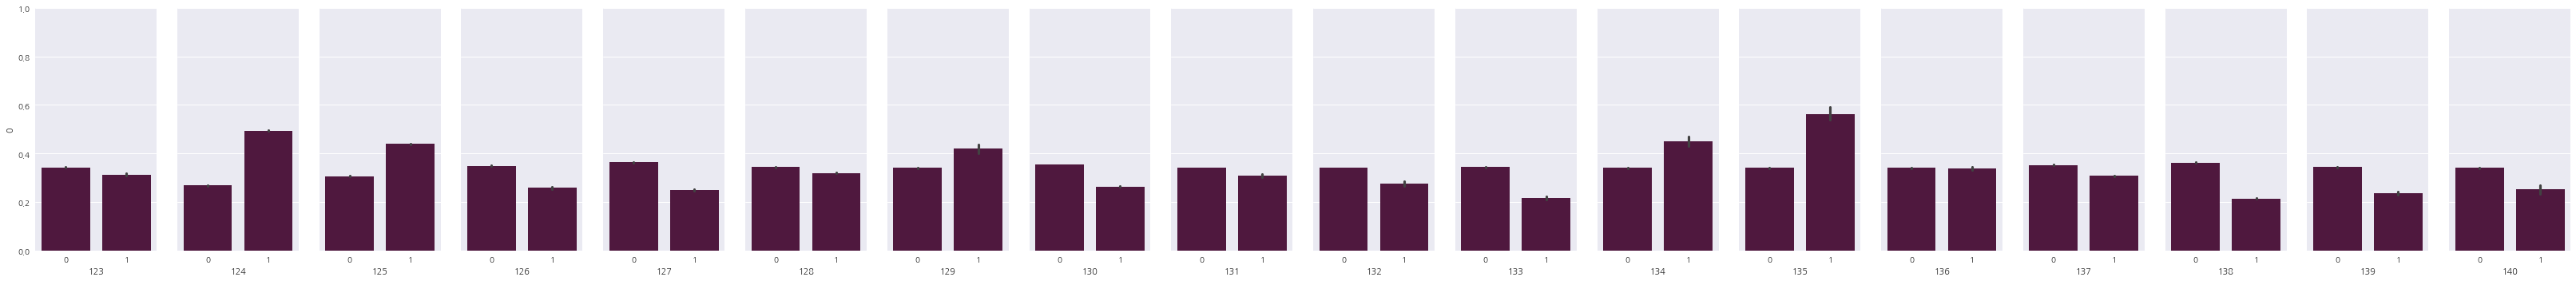

In [32]:
graph3 = sns.PairGrid(data, y_vars=0,
                 x_vars= data.iloc[:, 123:141].columns,
                 size=5, aspect=.5)
graph3.map(sns.barplot, color=sns.xkcd_rgb["plum"])
graph3.set(ylim=(0, 1))
sns.despine(fig=graph2.fig, left=True)

### 해당 작품의 마지막 에피소드 발행 시점과 1시간 이내 구매 여부와의 관계
* 범위별로 부여된 순차 ID
* 해당 작품의 마지막 에피소드 발행시점이 10일 경우 구매비율이 높은 것을 알 수 있다.
* 해당 작품의 마지막 에피소드 발행시점이 18일 경우 구매비율이 가장 낮은 것을 알 수 있다.

In [33]:
data[141].value_counts()

19    479004
18     46478
17     29524
16     25366
13     13280
14     12665
15     11848
12      7491
10      6656
9       4869
11      3245
6       2557
7       2486
8       2065
4       1784
5        800
2        576
3        271
Name: 141, dtype: int64

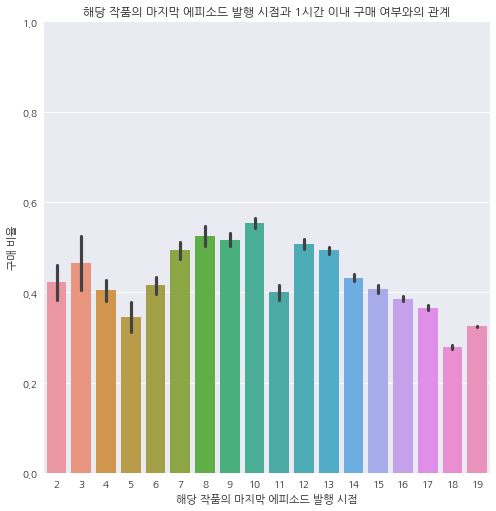

In [34]:
sns.factorplot(x=141, y=0, data=data, kind='bar', size=7)
plt.xlabel('해당 작품의 마지막 에피소드 발행 시점')
plt.ylabel('구매 비율')
plt.title('해당 작품의 마지막 에피소드 발행 시점과 1시간 이내 구매 여부와의 관계')
plt.ylim(0, 1)
plt.show()

### 단행본 여부와 1시간 이내 구매 여부와의 관계
* 단행본 여부와 구매 여부와의 관계는 그래프 상으로 볼 때 크게 관계가 있지 않은 것으로 판단된다.

In [35]:
data.loc[:, 142].head()

0    1
1    1
2    1
3    1
4    0
Name: 142, dtype: int64

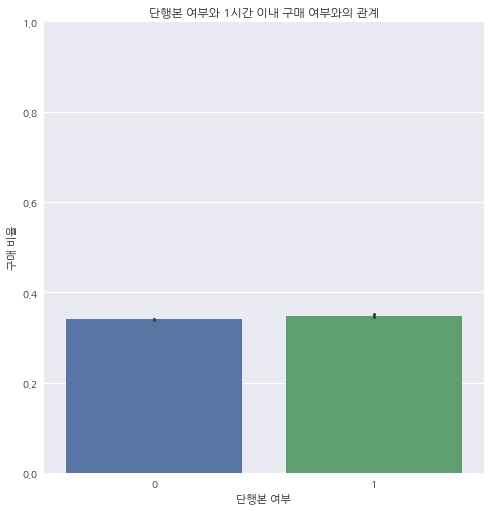

In [36]:
sns.factorplot(x=142, y=0, data=data, kind='bar', size=7)
plt.xlabel('단행본 여부')
plt.ylabel('구매 비율')
plt.title('단행본 여부와 1시간 이내 구매 여부와의 관계')
plt.ylim(0, 1)
plt.show()

### 작품 발행 시점과 1시간 이내 구매 여부와의 관계
* 범위별로 부여된 순차적 ID
* 작품 발행 시점이 6일 때 가장 구매 비율이 높은 것을 확인할 수 있다.
* 그리고 작품 시점이 17일 경우 구매비율이 가장 낮은 것을 확인할 수 있다.

In [37]:
data.loc[:,143].value_counts()

18    90870
19    88555
16    78638
15    71300
14    50716
17    46889
13    39041
12    38809
11    32578
10    25481
7     23721
5     14377
2     10730
4      9261
9      8683
3      7876
6      7200
8      6240
Name: 143, dtype: int64

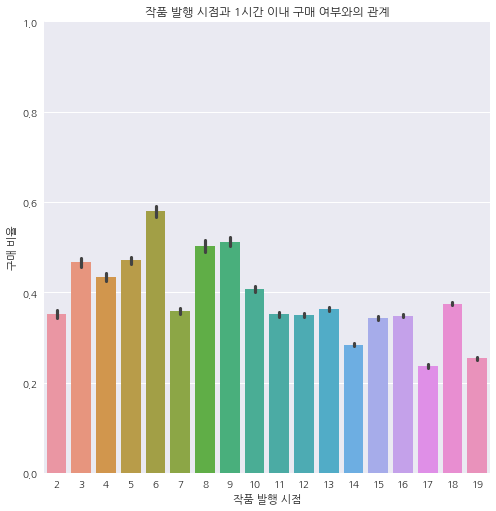

In [38]:
sns.factorplot(x=143, y=0, data=data, kind='bar', size=7)
plt.xlabel('작품 발행 시점')
plt.ylabel('구매 비율')
plt.title('작품 발행 시점과 1시간 이내 구매 여부와의 관계')
plt.ylim(0, 1)
plt.show()

### 총 발행 에피소드 수와 1시간 이내 구매 여부와의 관계
* 범위별로 부여된 순차 ID

In [39]:
data[144].value_counts()

1     132461
2      82432
4      81051
5      77817
3      61038
9      37049
7      36696
6      35406
0      32370
8      22566
10      9561
13      9013
14      8432
16      6689
11      6274
17      3967
15      2312
12      1908
20      1601
18      1258
21       409
22       297
25       294
19        49
28         5
42         4
26         4
45         2
Name: 144, dtype: int64

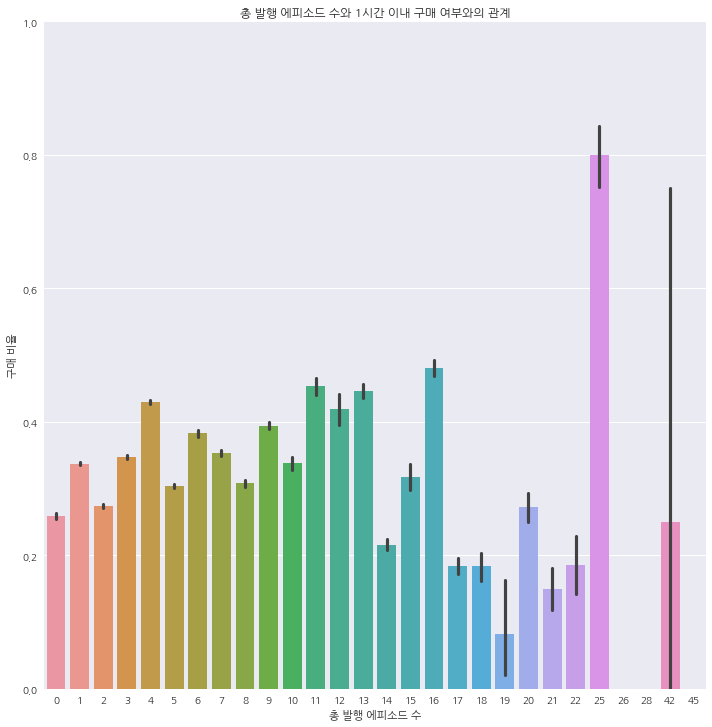

In [40]:
sns.factorplot(x=144, y=0, data=data, kind='bar', size=10)
plt.xlabel('총 발행 에피소드 수')
plt.ylabel('구매 비율')
plt.title('총 발행 에피소드 수와 1시간 이내 구매 여부와의 관계')
plt.ylim(0, 1)
plt.show()

### 작품 태그 정보와 1시간 이내 구매 여부 관계

* 147, 149 태그 정보의 경우 태그정보가 있으면 구매 비율이 높아지는 것을 알 수 있다.
* 148, 150 태그정보의 경우 태그정보가 있으면 없을 때 보다 약간 구매비율이 상승하는 것을 볼 수 있다.

In [41]:
data.iloc[:,145:151].head()

,145,146,147,148,149,150
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


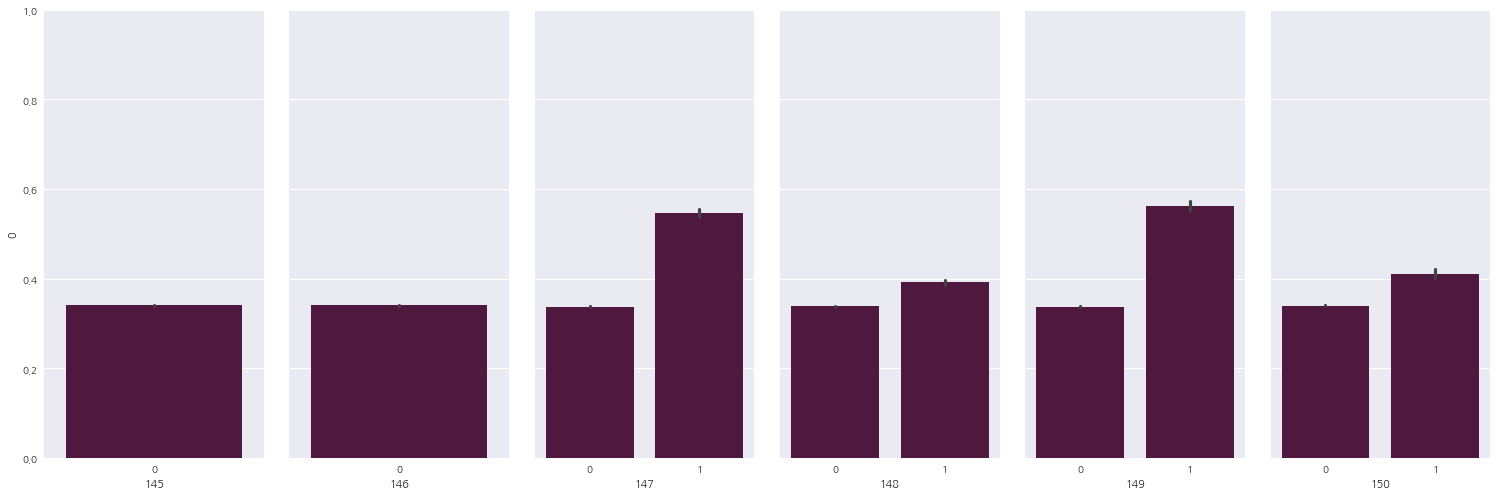

In [42]:
graph4 = sns.PairGrid(data, y_vars=0,
                 x_vars= data.iloc[:, 145:151].columns,
                 size=7, aspect=.5)
graph4.map(sns.barplot, color=sns.xkcd_rgb["plum"])
graph4.set(ylim=(0, 1))
sns.despine(fig=graph4.fig, left=True)

### 유저의 성향 정보와 1시간 이내 구매 여부 관계
* 과거 구매 했을 때만 기록 되어 있으므로 NaN으로 표시되어 있는 부분은 0으로 채우기
* nan값이 너무 많아서 일단 0으로 채우긴 했는데 heatmap 상으로 볼 때는 유저 성향 정보와 1시간 이내 구매 여부 관계는 크게 상관 없는 것으로 판단된다.

In [43]:
data_copy = data.copy()
data_copy.fillna(0, axis=1, inplace=True)
data_copy.iloc[:, 151:167].head()

,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166
0,0.0,0.1952,0.3310,0.0,0.1490,0.0000,0.0,0.0000,0.0000,0.0,0.0,0.0,0.2580,0.0030,0.0,0.0
1,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.5000,0.0000,0.0,0.0,0.0,0.5000,0.0000,0.0,0.0
2,0.0,0.4615,0.4596,0.0,0.0142,0.0072,0.0,0.0187,0.0047,0.0,0.0,0.0,0.0287,0.0055,0.0,0.0
3,0.0,0.8390,0.0813,0.0,0.0611,0.0000,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0186,0.0000,0.0,0.0
4,0.0,0.1571,0.4217,0.0,0.0368,0.0140,0.0,0.0207,0.0000,0.0,0.0,0.0,0.2805,0.0692,0.0,0.0


In [44]:
user_info = data_copy.iloc[:, 151:167]
user_info_and_target = pd.concat([user_info, data[0]], axis=1)
user_info_and_target.head()

,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,0
0,0.0,0.1952,0.3310,0.0,0.1490,0.0000,0.0,0.0000,0.0000,0.0,0.0,0.0,0.2580,0.0030,0.0,0.0,0
1,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.5000,0.0000,0.0,0.0,0.0,0.5000,0.0000,0.0,0.0,0
2,0.0,0.4615,0.4596,0.0,0.0142,0.0072,0.0,0.0187,0.0047,0.0,0.0,0.0,0.0287,0.0055,0.0,0.0,0
3,0.0,0.8390,0.0813,0.0,0.0611,0.0000,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0186,0.0000,0.0,0.0,0
4,0.0,0.1571,0.4217,0.0,0.0368,0.0140,0.0,0.0207,0.0000,0.0,0.0,0.0,0.2805,0.0692,0.0,0.0,0


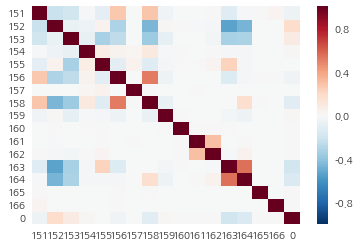

In [45]:
sns.heatmap(user_info_and_target.corr())
plt.show()